In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines
import os
from IPython.display import display
import networkx as nx
import statistics
import scipy.stats as st
from sklearn.metrics import jaccard_score
from haversine import haversine
import math

In [2]:
df_martix = pd.read_csv('./study_data/cities_gzh_aja_martix.csv')
df_citys = pd.read_csv('./study_data/sa340.csv')
df_martix.set_index('city', inplace=True)
rank = pd.read_csv('./study_data/score/城市信息+排名得分综合表.csv')
df_in_out = pd.read_csv('./study_data/all_cities_in_out_count.csv')

In [3]:
rank.columns

Index(['citycode', 'adcode', 'name', 'level', 'center', 'pro_name',
       'pro_adcode', 'gzh', 'city_shortname', 'pro_shortname', 'en_name',
       'in_citation', 'citation_score', 'pagerank_value', 'pagerank_rank',
       'importance_score', 'pagerank_score', 'Longitude', 'Latitude', 'ARI',
       'GEO', 'HAR'],
      dtype='object')

# intensity of Inter-City Connections

In [6]:
def inter_city_connectivity_value(cityA, cityB):
    _delta = 1/340 
    # B城市提及了多少次A
    v_B2A = df_martix.loc[cityB, cityA]
    # A提及了多少次B
    v_A2B = df_martix.loc[cityA, cityB]
    # CII_A = rank[rank.name==cityA]['ARI'].values[0]
    # CII_B = rank[rank.name==cityB]['ARI'].values[0]
    
    return math.sqrt(v_B2A * v_A2B)

def get_connectivity_intensity(city):
    city_list = rank['name'].tolist()
    datas = []
    for i in city_list:
        if city != i:
            v = inter_city_connectivity_value(city, i)
            # 有值才有联系度
            if v != 0:
                datas.append([city, i, v])
    temp = pd.DataFrame(datas, columns=['city_a', 'city_b', 'intensity'])
    temp = temp.sort_values(by='intensity', ascending=False)
    return temp

## 可视化

In [7]:
#//networkx
pro_en = pd.read_csv('./study_data/省英文名称.csv')

# 自定义同心圆布局
def star_layout_with_equal_edge_length(G, target_city, edge_length=1):
    pos = {}
    nodes = list(G.nodes)
    center_node = target_city
    peripheral_nodes = [node for node in nodes if node != center_node]
    pos[center_node] = np.array([0, 0])
    
    for i, node in enumerate(peripheral_nodes):
        angle = 2 * np.pi * i / len(peripheral_nodes)
        pos[node] = np.array([np.cos(angle), np.sin(angle)]) * edge_length
    
    return pos

def show_graph(city, is_CN=False): 
    temp = get_connectivity_intensity(city)[0:20]
    display(temp)
 
    nodes_cn_name = list(set(temp['city_a'].tolist() + temp['city_b'].tolist()))
    nodes = pd.DataFrame(nodes_cn_name, columns=['name'])
    nodes = pd.merge(nodes, rank, on='name')[['name', 'ARI', 'Longitude', 'Latitude', 'pro_name', 'en_name']]
    
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    G = nx.from_pandas_edgelist(temp, 'city_a', 'city_b', edge_attr=['intensity'])
    
    # 绘制的权重
    edge_weights = [G[u][v]['intensity']/10 for u, v in G.edges()]
    # 边的标签
    edge_labels = {(u, v): "{:.2f}".format(d['intensity']) for u, v, d in G.edges(data=True)}
    
    node_sizes = []
    labels = {}
    
    for node in G.nodes():
        # CII 表示大小
        # 0位小数
        node_sizes.append(round(list(nodes[nodes.name==node]['ARI'])[0], 2) * 20)
        # node 标签
        pro_cn_name = list(nodes[nodes.name==node]['pro_name'])[0]
        pro_en_name = list(pro_en[pro_en.pro_name==pro_cn_name]['en_short'])[0]
        lb = list(nodes[nodes.name==node]['en_name'])[0].replace('Prefecture', '').replace('Autonomous', '') + '(' + pro_en_name + ')'
        
        if is_CN:
            labels[node] = node
        else:
            labels[node] = lb

    FZ = 13
    
    # 布局
    pos = star_layout_with_equal_edge_length(G, city)
    # pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(7, 7)) 
    nx.draw(G, pos, with_labels=True, 
            labels=labels,
            node_color='#5CD38E', 
            node_size=node_sizes, font_size=FZ, font_color='black', 
            font_weight=600,
            edge_color = '#F13919',
            width=edge_weights)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=FZ + 5, font_color='black', bbox={'alpha': 0})
    prefix = './地图_QGIS/inter-city-intensity/cities/city_intensity_en_'
    if is_CN: 
        prefix = './地图_QGIS/inter-city-intensity/cities/city_intensity_cn_'
    
    plt.savefig(prefix + city + '.pdf', format='pdf', dpi=600, bbox_inches = 'tight')
    plt.show()

## 绘制地图使用数据

In [9]:
# for qgis
def add_edges_nodes_to_csv(cities, name):
    dfs = []
    # /////////////////////////////////////////////////
    for city in cities:
        df = get_connectivity_intensity(city)[0:20]
        dfs.append(df)
    temp = pd.concat(dfs)


    city_nodes = list(set(temp['city_a'].values)) + list(set(temp['city_b'].values))
    city_nodes = list(set(city_nodes))
    city_nodes = rank[rank.name.isin(city_nodes)][['name', 'en_name','ARI','Longitude', 'Latitude']]
    # 这里去掉样本城市的标签，因为下面要加大加粗字体
    city_nodes.loc[city_nodes['name'].isin(cities), 'en_name'] = ''
    
    # /////////////////////////////////////////////////
    # 样本城市高亮（这个用于显示节点的标签，需要加大加粗字体）
    sample_nodes = rank[rank.name.isin(cities)][['name', 'en_name','ARI','Longitude', 'Latitude']]

    temp.to_csv('./地图_QGIS/inter-city-intensity/' + name + '_edges.csv', index=None)
    city_nodes.to_csv('./地图_QGIS/inter-city-intensity/' + name + '_nodes.csv', index=None)
    sample_nodes.to_csv('./地图_QGIS/inter-city-intensity/' + name + '_nodes_sample.csv', index=None)
    
    return temp

### 一线到五线城市，各选一个

In [11]:
def do_do(cities, name):
    add_edges_nodes_to_csv(cities, name)
    for i in cities:
        show_graph(i)

,city_a,city_b,intensity
14,上海市,苏州市,300.649297
3,上海市,杭州市,157.949359
9,上海市,南京市,152.947703
20,上海市,合肥市,151.525575
60,上海市,嘉兴市,133.917885
57,上海市,南通市,132.049233
5,上海市,成都市,129.830659
36,上海市,黄山市,114.542569
16,上海市,宁波市,106.489436
0,上海市,北京市,105.118980


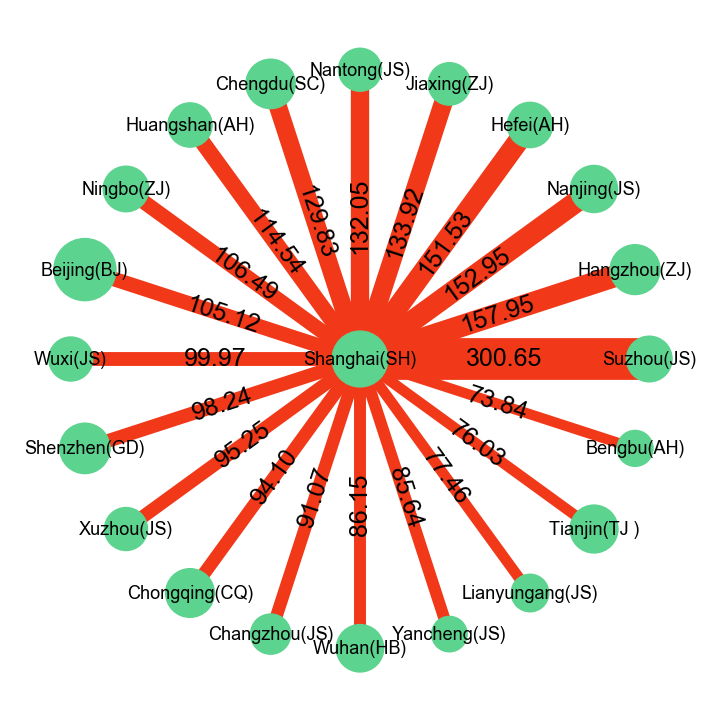

,city_a,city_b,intensity
36,杭州市,金华市,202.908847
16,杭州市,宁波市,180.138835
57,杭州市,绍兴市,169.799882
1,杭州市,上海市,157.949359
31,杭州市,温州市,157.038212
69,杭州市,湖州市,150.313007
59,杭州市,嘉兴市,146.355731
85,杭州市,台州市,131.795296
102,杭州市,衢州市,117.460632
81,杭州市,丽水市,111.687063


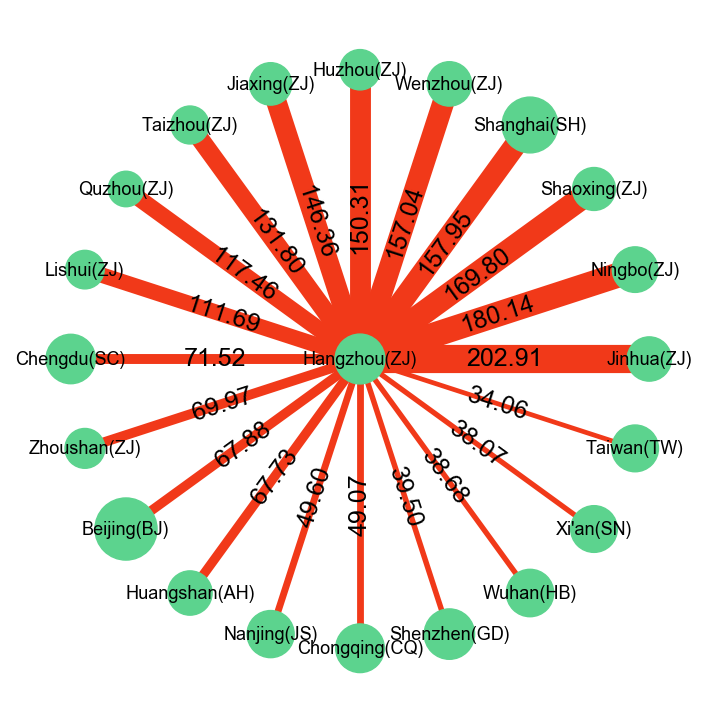

,city_a,city_b,intensity
11,珠海市,澳门特别行政区,264.204466
3,珠海市,深圳市,102.332790
24,珠海市,中山市,96.483159
47,珠海市,江门市,89.246849
2,珠海市,广州市,71.386273
25,珠海市,佛山市,56.868269
88,珠海市,遵义市,49.799598
5,珠海市,香港特别行政区,42.426407
76,珠海市,阳江市,41.231056
45,珠海市,汕头市,36.660606


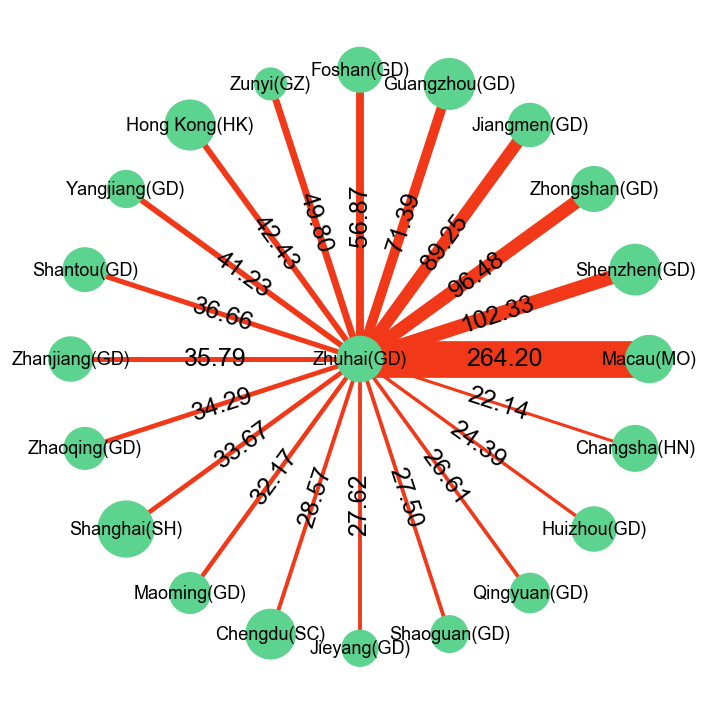

,city_a,city_b,intensity
11,安庆市,合肥市,98.954535
25,安庆市,芜湖市,53.103672
59,安庆市,宿州市,44.497191
63,安庆市,铜陵市,42.426407
38,安庆市,阜阳市,39.572718
0,安庆市,上海市,38.340579
47,安庆市,蚌埠市,36.331804
46,安庆市,淮南市,35.707142
44,安庆市,马鞍山市,35.327043
65,安庆市,亳州市,32.326460


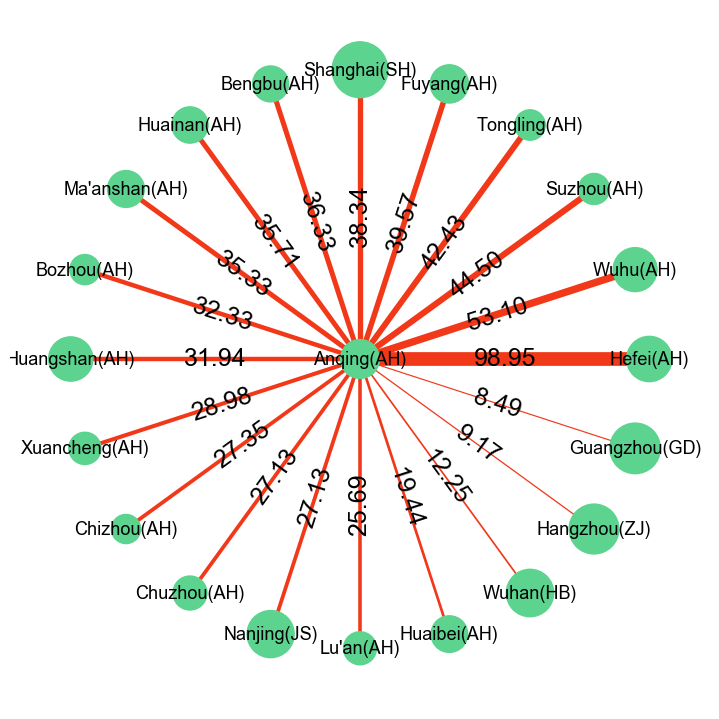

,city_a,city_b,intensity
19,景德镇市,南昌市,118.886500
51,景德镇市,九江市,77.420927
95,景德镇市,鹰潭市,54.387499
79,景德镇市,上饶市,50.497525
89,景德镇市,宜春市,49.497475
86,景德镇市,抚州市,46.829478
94,景德镇市,新余市,39.344631
87,景德镇市,萍乡市,38.884444
54,景德镇市,赣州市,34.176015
88,景德镇市,吉安市,33.585711


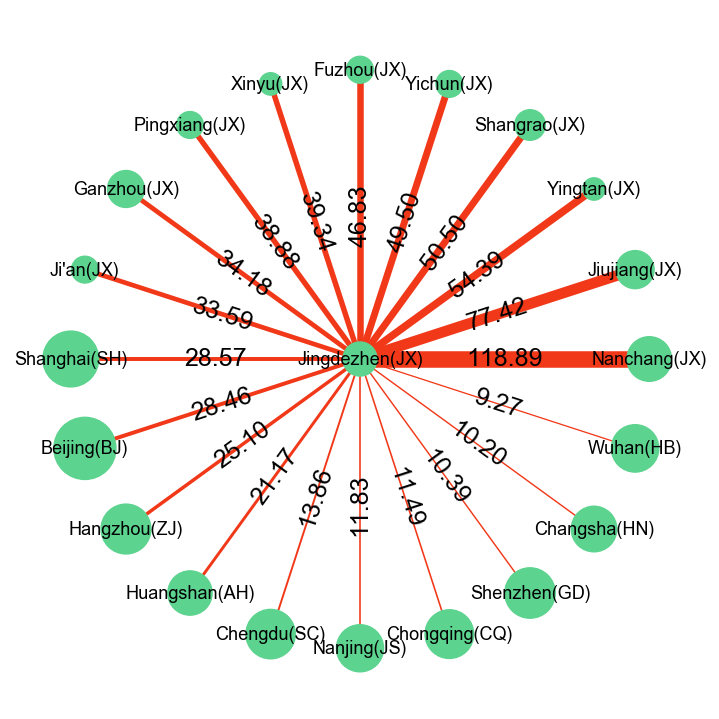

,city_a,city_b,intensity
0,鹤岗市,哈尔滨市,35.411862
5,鹤岗市,佳木斯市,15.231546
1,鹤岗市,汕头市,9.797959
4,鹤岗市,齐齐哈尔市,9.219544
6,鹤岗市,伊春市,7.874008
3,鹤岗市,牡丹江市,4.123106
7,鹤岗市,鸡西市,1.732051
2,鹤岗市,黑河市,1.414214


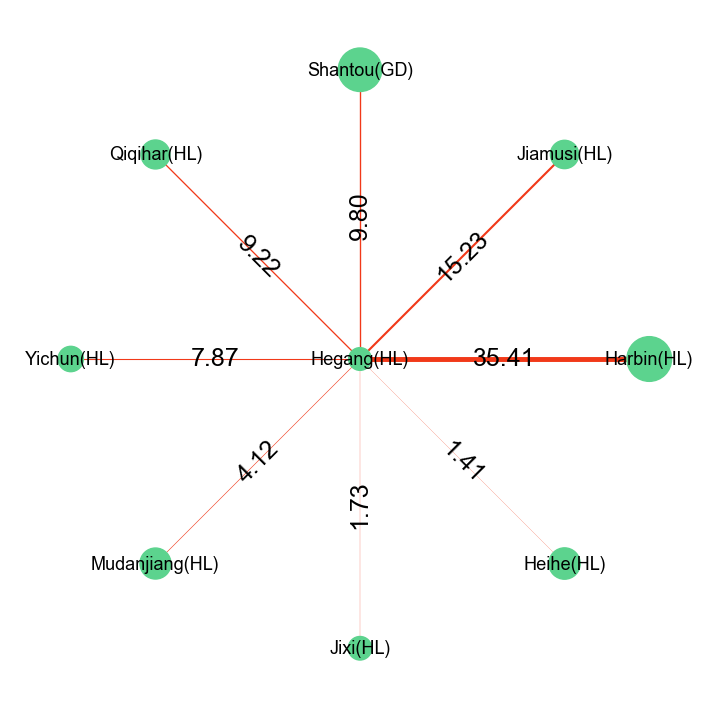

,city_a,city_b,intensity
3,香港特别行政区,深圳市,138.679487
9,香港特别行政区,澳门特别行政区,62.161081
11,香港特别行政区,珠海市,42.426407
2,香港特别行政区,广州市,30.331502
0,香港特别行政区,北京市,30.298515
1,香港特别行政区,上海市,29.154759
6,香港特别行政区,重庆市,21.725561
12,香港特别行政区,中山市,19.595918
14,香港特别行政区,东莞市,18.654758
13,香港特别行政区,佛山市,17.378147


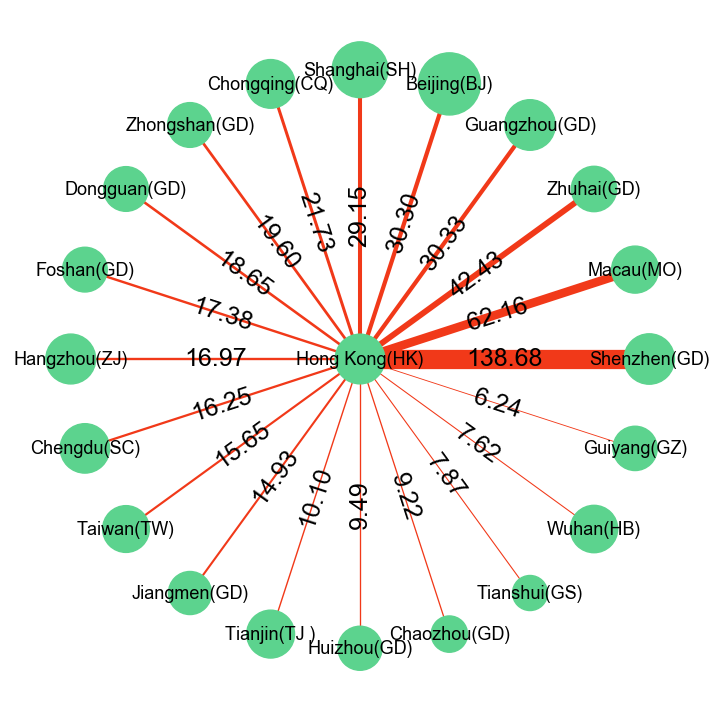

,city_a,city_b,intensity
23,广州市,佛山市,128.121037
2,广州市,深圳市,124.996000
22,广州市,中山市,89.632583
25,广州市,东莞市,73.749576
56,广州市,清远市,72.477583
41,广州市,汕头市,72.415468
68,广州市,韶关市,72.332565
19,广州市,珠海市,71.386273
37,广州市,湛江市,64.807407
36,广州市,惠州市,63.623895


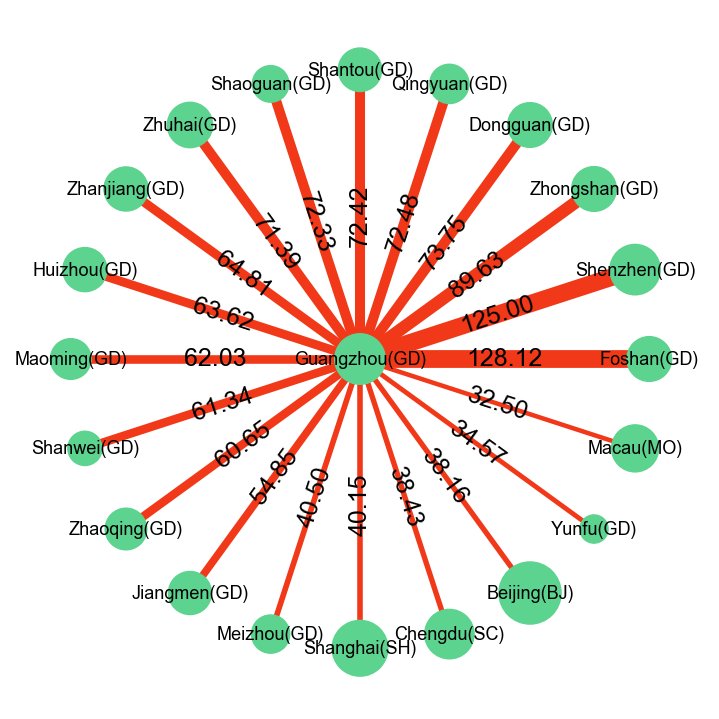

,city_a,city_b,intensity
7,北京市,天津市,239.382539
5,北京市,成都市,116.833214
0,北京市,上海市,105.118980
73,北京市,廊坊市,96.840074
6,北京市,重庆市,83.964278
2,北京市,深圳市,83.426614
11,北京市,台湾省,78.803553
60,北京市,保定市,75.736385
3,北京市,杭州市,67.882251
92,北京市,沧州市,64.015623


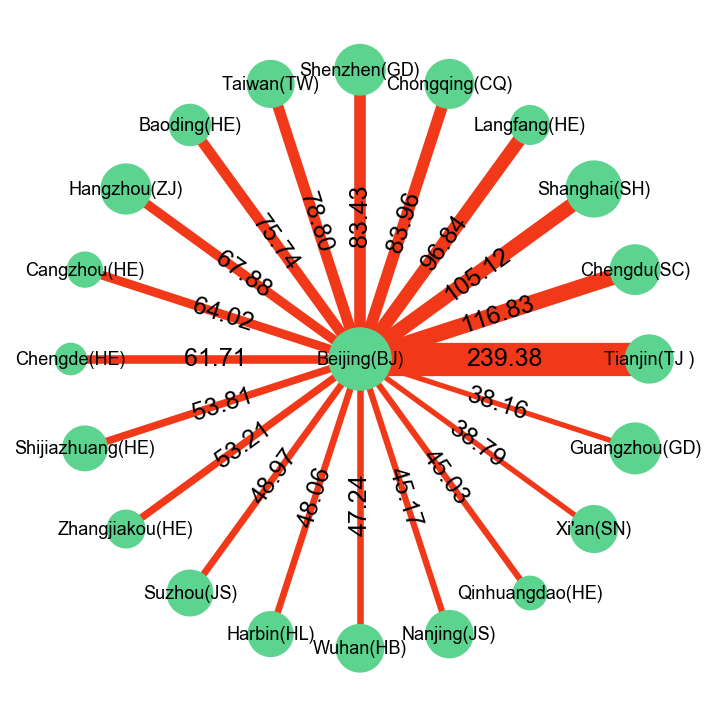

In [12]:
cities_level_0_5 = ['上海市', '杭州市', '珠海市', '安庆市', '景德镇市', '鹤岗市', 
                    '香港特别行政区', '广州市','北京市']
do_do(cities_level_0_5, 'level_0_5')